In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [2]:
import dipy.reconst.sfm as sfm
import dipy.core.gradients as grad

In [3]:
"%—voxel1——-voxel2——-voxel3-—-voxel4——-voxel5——-voxel6"
seen_signal_x = np.loadtxt('./seenSignaX.txt', skiprows=1)
seen_signal = np.loadtxt('./seenSignal.txt', skiprows=1)

In [4]:
"%--dir-x---dir-y----dir-z-----|G|-----DELTA---delta-----TE---"
seen_scheme = np.loadtxt('./seenScheme.txt', skiprows=1)
unseen_scheme = np.loadtxt('./unseenScheme.txt', skiprows=1)

In [5]:
seen_bvecs = seen_scheme[:, :3]

In [6]:
def b_value(g, delta, Delta, gamma=42.576):
    """ 
    Calculate the b value
    
    Parameters
    ----------
    g : gradient strength (mT/m, typically around 40)
    delta : gradient duration
    Delta : diffusion duration
    gamma : the gyromagnetic ration (42.576 MHz/T for Hydrogen)
    
    """
    G = g*1e-3*1e-6 #convert to T/um
    gamma = 2*np.pi*gamma*1e6*1e-3 # convert to 1/ms/T (Hz = cycles/sec, 1 cycle = 2pi = 2pi/sec)
    b = gamma ** 2 * G ** 2 * delta ** 2 * (Delta-delta/3) # millisecons/micrometer^2  
    return 1000 * b #s/mm^2

In [7]:
g = seen_scheme[:, 3] * 1000 #mT/m
Delta = seen_scheme[:, 4] * 1000 
delta = seen_scheme[:, 5] * 1000
TE = seen_scheme[:, 6] * 1000 # msec

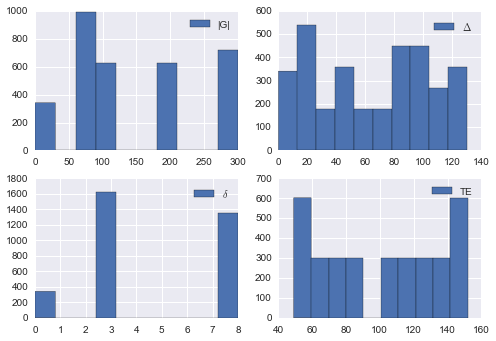

In [8]:
fig, ax = plt.subplots(2, 2)
for a, stat, label in zip(ax.ravel(), 
                          [g, Delta, delta, TE], 
                          ['|G|', '$\Delta$', '$\delta$', 'TE']):
    a.hist(stat, label=label)
    a.legend()

In [9]:
seen_bvals = b_value(g, delta, Delta)

In [10]:
train_data = seen_signal[:, 0][::2]
train_bvals = seen_bvals[::2]
train_bvecs = seen_bvecs[::2]
train_delta = delta[::2]
train_Delta = Delta[::2]
train_te = TE[::2]

In [11]:
train_gtab = grad.gradient_table(train_bvals, train_bvecs, big_delta=Delta, small_delta=delta)
# How should we use the information from the TE? 
train_gtab.TE = train_te

In [12]:
sf_model = sfm.SparseFascicleModel(train_gtab, isotropic=sfm.ExponentialIsotropicModel)

In [13]:
sf_fit = sf_model.fit(train_data)

In [14]:
predict = sf_fit.predict()

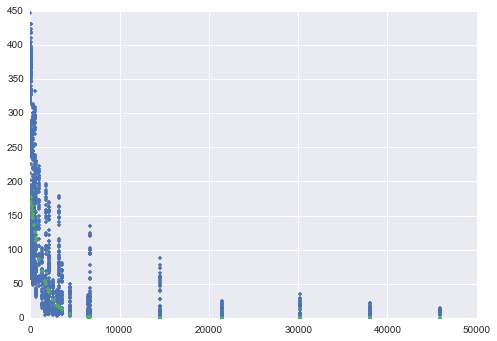

In [15]:
plt.plot(train_gtab.bvals, train_data, '.')
plt.plot(train_gtab.bvals[~train_gtab.b0s_mask], sf_fit.iso*np.mean(train_data[train_gtab.b0s_mask]), '.')

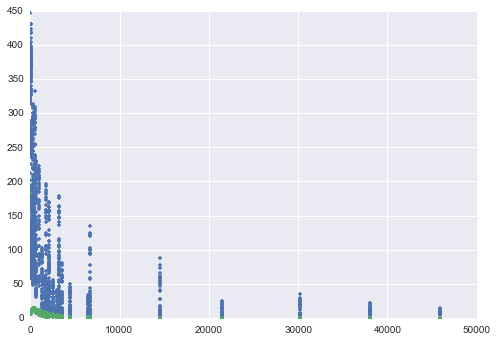

In [16]:
plt.plot(train_gtab.bvals, train_data, '.')
plt.plot(train_gtab.bvals, predict, '.')

In [17]:
def LSE(prediction, signal, sigma=8):
    return np.sum(((signal - np.sqrt(signal**2 + sigma**2))**2)/(sigma**2))

In [18]:
LSE(predict, train_data)

89.169272016140866